In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/home/pedranji/Projects/carPerformance/data/ElectricMotorMeasures/measures_v2.csv")


### Dataset description
- u_q: Voltage q-component measurement in dq-coordinates (in V)
- coolant : coolant temperature in °C
- stator_winding: Stator winding temperature (in °C) measured with thermocouples
- u_d : Voltage d-component measurement in dq-coordinates
- stator_tooth : Stator tooth temperature (in °C) measured with thermocouples
- motor_speed : Motor speed (in rpm)
- i_d : Current d-component measurement in dq-coordinates
- pm : Permanent Magnet temperature (in °C) measured with thermocouples and transmitted wirelelessly via a thermography unit.
- stator_yoke : Stator yoke temperature (in °C) measured with thermocouples
- ambient : Ambient temperature (in °C)
- torque : Motor torque (in Nm)
- profile_id : Measurement session id. Each distinct measurement session can be identified through this integer id.

This dataset is from (kaggle)[https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature]. Thanks.

### Objective
Predict engine torque based on the other features. This is due to the fact that it is not economically wise to measure torque in a normal production vehicle.
Another interesting measure to predict is rotor temperature (pm), which wouldn't be sound to measure in a production vehicle.


In [3]:
# reorder columns so that torque is the last column and profile_id is the first column
df = df[["profile_id", "ambient", "coolant", "u_d", "u_q","motor_speed", "i_d", "i_q", "pm", "stator_yoke", "stator_tooth", "stator_winding",  "torque"]]

In order to do this, we will use a Recursive Neural Network. This is due to the fact that the data is organized in a time series. Not taking this important fact into account would be suboptimal, given that datapoints are affected by the previous ones. For example, a high torque value at time t-1 will most likely result in a high torque value at time t.

### Scaling: Normalization

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Create a copy to maintain the original dataframe.
df_scaled = df.copy(deep=True)

# Apply the scaler to the data subset (all columns except the 'profile_id' and 'motor_speed' columns)
for col in df_scaled.columns[2:-1]:
    df_scaled[col] = scaler.fit_transform(df_scaled[col].values.reshape(-1, 1))

# Apply the scaler to the target column in a separate scaler so that we can inverse transform later.
scaler_target = StandardScaler()
df_scaled["torque"] = scaler_target.fit_transform(df_scaled["motor_speed"].values.reshape(-1, 1))

<Axes: >

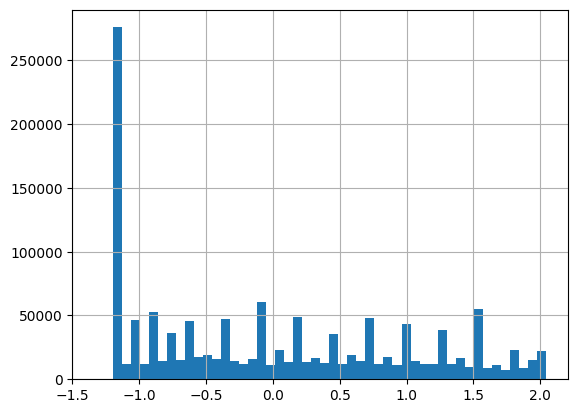

In [5]:
df_scaled["torque"].hist(bins=50)

In [6]:
# set index to the profile_id
df_scaled.set_index("profile_id", inplace=True)

In [7]:
df_scaled

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,torque
profile_id,,,,,,,,,,,,
17,19.850691,-0.799812,0.392820,-1.238979,-1.184128,1.058337,-0.405855,-1.786837,-1.494244,-1.681117,-1.648158,-1.184128
17,19.850672,-0.799197,0.393521,-1.236150,-1.184129,1.058278,-0.405867,-1.787686,-1.494323,-1.681047,-1.647959,-1.184129
17,19.850657,-0.798729,0.392464,-1.238757,-1.184128,1.058289,-0.405854,-1.787338,-1.493755,-1.681078,-1.648064,-1.184128
17,19.850647,-0.798417,0.393356,-1.236180,-1.184126,1.058270,-0.405836,-1.786847,-1.493529,-1.681146,-1.648285,-1.184126
17,19.850639,-0.797432,0.393101,-1.239442,-1.184127,1.057279,-0.405455,-1.786248,-1.493738,-1.681195,-1.648303,-1.184127
...,...,...,...,...,...,...,...,...,...,...,...,...
71,23.989078,-0.252853,0.410918,-1.277497,-1.184129,1.027466,-0.393952,0.191617,-0.476927,-0.651102,-0.734801,-1.184129
71,23.970700,-0.252853,0.410713,-1.279909,-1.184128,1.027461,-0.393952,0.191347,-0.476796,-0.653952,-0.736038,-1.184128
71,23.977234,-0.252853,0.411126,-1.277003,-1.184128,1.027480,-0.393939,0.191122,-0.477067,-0.656745,-0.736995,-1.184128


### Feature importance


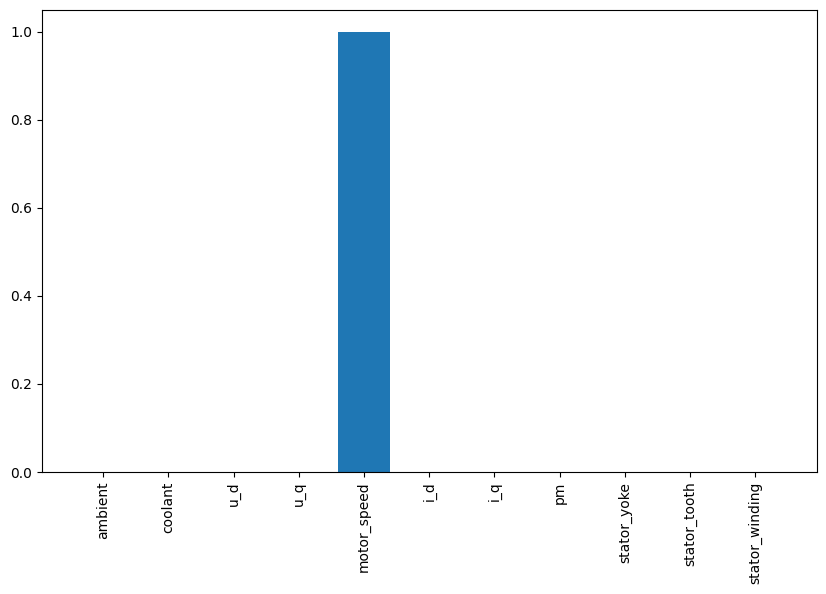

In [10]:
from sklearn.ensemble import RandomForestRegressor

df_sample = df_scaled.sample(frac=0.01, random_state=42)

rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(df_sample.drop(columns=["torque"]), df_sample["torque"])

#plot the feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(df_sample.drop(columns=["torque"]).columns, rf.feature_importances_)
plt.xticks(rotation=90)
plt.show()

This feature importance chart says that all features are almost irrelevant with the exception of the RPM, which makes a lot of sense, given that the torque can be thought of proportional to the RPM. This makes the problem a lot simpler, since we can just use the RPM to predict the torque. This is a good example of how feature engineering can be more important than the model itself.

In [11]:
# drop the features with low importance
df_scaled = df_scaled[["motor_speed", "torque"]]

sequence generation? let's try timedistributed first and then see if I need to go back here

label generation?

### Data split

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_scaled["motor_speed"], df_scaled["torque"], test_size=0.2, random_state=42)

X_train = X_train.values.reshape(-1, 1, 1)
X_test = X_test.values.reshape(-1, 1, 1)
y_train = y_train.values.reshape(-1, 1, 1)
y_test = y_test.values.reshape(-1, 1, 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1064652, 1, 1)
(266164, 1, 1)
(1064652, 1, 1)
(266164, 1, 1)


Data loader?

### Model
Time Distributed!

In [85]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, TimeDistributed, SimpleRNN


simple_rnn = Sequential()
simple_rnn.add(TimeDistributed(LSTM(128, return_sequences=True), input_shape=(None, 1, 1)))
simple_rnn.add(TimeDistributed(Dropout(0.2)))
simple_rnn.add(TimeDistributed(LSTM(128, return_sequences=True)))
simple_rnn.add(TimeDistributed(Dropout(0.2)))
simple_rnn.add(TimeDistributed(Dense(1)))

simple_rnn.build(input_shape=(None, 1, 1))

simple_rnn.summary()

simple_rnn.compile(loss="mse", optimizer="adam", metrics=["mae"])

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_175 (Time  (None, None, 1, 128)      66560     
 Distributed)                                                    
                                                                 
 time_distributed_176 (Time  (None, None, 1, 128)      0         
 Distributed)                                                    
                                                                 
 time_distributed_177 (Time  (None, None, 1, 128)      131584    
 Distributed)                                                    
                                                                 
 time_distributed_178 (Time  (None, None, 1, 128)      0         
 Distributed)                                                    
                                                                 
 time_distributed_179 (Time  (None, None, 1, 1)      

In [86]:
H = simple_rnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
26617/26617 [==============================] - 168s 6ms/step - loss: 0.0046 - mae: 0.0455 - val_loss: 1.8278e-04 - val_mae: 0.0111
Epoch 2/10
26617/26617 [==============================] - 163s 6ms/step - loss: 0.0032 - mae: 0.0431 - val_loss: 2.4804e-05 - val_mae: 0.0047
Epoch 3/10
26617/26617 [==============================] - 159s 6ms/step - loss: 0.0031 - mae: 0.0417 - val_loss: 1.0430e-04 - val_mae: 0.0083
Epoch 4/10
26617/26617 [==============================] - 158s 6ms/step - loss: 0.0029 - mae: 0.0402 - val_loss: 9.3466e-04 - val_mae: 0.0245
Epoch 5/10
26617/26617 [==============================] - 159s 6ms/step - loss: 0.0028 - mae: 0.0394 - val_loss: 4.7605e-05 - val_mae: 0.0058
Epoch 6/10
26617/26617 [==============================] - 158s 6ms/step - loss: 0.0027 - mae: 0.0385 - val_loss: 1.9258e-04 - val_mae: 0.0103
Epoch 7/10
26617/26617 [==============================] - 162s 6ms/step - loss: 0.0026 - mae: 0.0378 - val_loss: 1.1387e-04 - val_mae: 0.0083
Epoch 

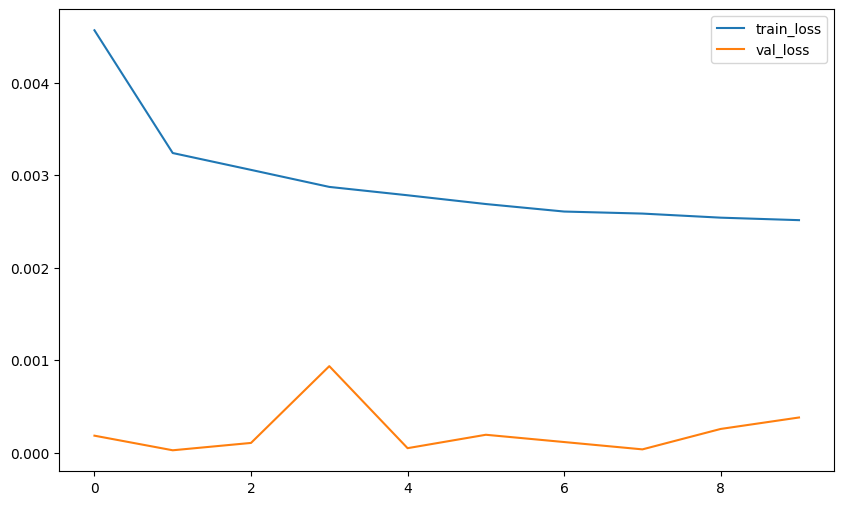

In [87]:
# plot loss
plt.figure(figsize=(10, 6))
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.legend()
plt.show()


In [90]:
# predictions
y_pred = simple_rnn.predict(X_test)



   1/8318 [..............................] - ETA: 4:17

8318/8318 [==============================] - 18s 2ms/step


In [97]:
print(y_pred.shape)
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# get accuracy, MAE, and MSE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("R2: ", r2_score(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

(266164, 1)
R2:  0.9996199853514788
MAE:  0.015994675248018005
MSE:  0.00037956776843092055
RMSE:  0.019482499029408948


In conclusion, this simple RNN model was able to predict great results with only two LSTM layers. One thing that is key is the TimeDistributed layer, which enabled the model to learn the sequence of the data without needing to pad/truncate the sequences, which ends up making the model more complex or, in the other case, losing information.